In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
from tensorflow.keras.models import load_model
from sklearn.metrics import jaccard_score, precision_score, recall_score
from sklearn.metrics import f1_score as f1_metric
import pandas as pd
from datetime import datetime

from preprocess import crop, padder, crop_to_coordinates
from helpers import f1

def inference_single_model(model, image_dir, time_steps=15, kernel_size=5, patch_size=256):
    """
    Run inference for a single model and return metrics.
    """
    # Load image file names
    files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    mask_dir = image_dir

    # Metrics storage
    all_f1, all_iou, all_precision, all_recall = [], [], [], []

    num_sequences = len(files) // time_steps
    for seq_idx in range(num_sequences):
        seq_files = files[seq_idx * time_steps:(seq_idx + 1) * time_steps]
        frames_padded = []
        stats, centroids = None, None

        # Preprocess each frame in the sequence
        for file in seq_files:
            img_path = os.path.join(image_dir, file)
            image = cv2.imread(img_path, 0)  # Grayscale
            image_cropped, stats, centroids = crop(image, kernel_size=kernel_size)
            image_color = cv2.cvtColor(image_cropped, cv2.COLOR_GRAY2RGB)
            image_np = image_color / 255.0
            image_padded = padder(image_np, patch_size=patch_size)
            frames_padded.append(image_padded)

        frames_padded = np.array(frames_padded)  # (time_steps, H, W, 3)
        H, W, _ = frames_padded[0].shape

        # Patchify all frames
        patches_seq = []
        for t in range(time_steps):
            patches = patchify(frames_padded[t], (patch_size, patch_size, 3), step=patch_size)
            patches_seq.append(patches)

        patches_seq = np.stack(patches_seq, axis=2)
        num_x, num_y = patches_seq.shape[:2]

        # Reshape to (num_patches, time_steps, patch_size, patch_size, 3)
        patches_seq = patches_seq.reshape(-1, time_steps, patch_size, patch_size, 3)

        # Predict masks for all time steps
        predicted_patches = model.predict(patches_seq, verbose=0)

        # Reshape back to (num_x, num_y, time_steps, patch_size, patch_size)
        predicted_patches = predicted_patches.reshape(num_x, num_y, time_steps, patch_size, patch_size)

        # Process each frame
        for t in range(time_steps):
            predicted_mask = unpatchify(predicted_patches[:, :, t, :, :], (H, W))
            prediction_bool = (predicted_mask > 0.5).astype(np.uint8)

            # Load corresponding ground truth mask
            mask_filename = seq_files[t].replace('.png', '.tif')
            mask_path = os.path.join(mask_dir, mask_filename)
            if not os.path.exists(mask_path):
                print(f"  Mask for {seq_files[t]} not found, skipping frame...")
                continue

            mask = cv2.imread(mask_path, 0)
            mask = crop_to_coordinates(mask, stats, centroids)
            mask = padder(mask, patch_size=patch_size)
            mask_bool = (mask > 0.5).astype(np.uint8)

            if np.sum(mask_bool) == 0:
                print(f"  Skipping frame {seq_files[t]} as ground truth has no positive pixels.")
                continue

            # Compute metrics
            pred_flat = prediction_bool.flatten()
            mask_flat = mask_bool.flatten()
            f1_val = f1_metric(mask_flat, pred_flat)
            iou_val = jaccard_score(mask_flat, pred_flat)
            precision_val = precision_score(mask_flat, pred_flat, zero_division=0)
            recall_val = recall_score(mask_flat, pred_flat, zero_division=0)

            all_f1.append(f1_val)
            all_iou.append(iou_val)
            all_precision.append(precision_val)
            all_recall.append(recall_val)

    # Calculate average metrics
    metrics = {
        'f1': np.mean(all_f1) if all_f1 else 0.0,
        'iou': np.mean(all_iou) if all_iou else 0.0,
        'precision': np.mean(all_precision) if all_precision else 0.0,
        'recall': np.mean(all_recall) if all_recall else 0.0,
        'num_frames': len(all_f1)
    }
    
    return metrics

def pipeline_all_models(models_dir, image_dir, time_steps=15, kernel_size=5, patch_size=256, 
                       model_extensions=['.h5', '.keras'], save_results=True):
    """
    Run inference on all models in a directory and compile results.
    
    Args:
        models_dir: Directory containing all model files
        image_dir: Directory containing test images
        time_steps: Number of time steps for LSTM models
        kernel_size: Kernel size for preprocessing
        patch_size: Patch size for patchifying
        model_extensions: List of model file extensions to look for
        save_results: Whether to save results to CSV
    
    Returns:
        DataFrame with results for all models
    """
    
    # Find all model files
    model_files = []
    for ext in model_extensions:
        model_files.extend([f for f in os.listdir(models_dir) if f.endswith(ext)])
    
    if not model_files:
        print(f"No model files found in {models_dir} with extensions {model_extensions}")
        return None
    
    print(f"Found {len(model_files)} models to evaluate:")
    for mf in model_files:
        print(f"  - {mf}")
    print("\n" + "="*60 + "\n")
    
    # Store results
    results = []
    
    # Process each model
    for idx, model_file in enumerate(model_files, 1):
        model_path = os.path.join(models_dir, model_file)
        model_name = os.path.splitext(model_file)[0]
        
        try:
            # Load model
            model = load_model(model_path, custom_objects={"f1": f1})
            
            # Run inference
            metrics = inference_single_model(
                model, 
                image_dir, 
                time_steps=time_steps,
                kernel_size=kernel_size,
                patch_size=patch_size
            )
            
            # Add model info to metrics
            metrics['model_name'] = model_name
            metrics['model_file'] = model_file
            
            # Print results for this model
            print(f"\n  Results for {model_name}:")
            print(f"    F1 Score:  {metrics['f1']:.4f}")
            print(f"    mIoU:      {metrics['iou']:.4f}")
            print(f"    Precision: {metrics['precision']:.4f}")
            print(f"    Recall:    {metrics['recall']:.4f}")
            print(f"    Frames:    {metrics['num_frames']}")
            
            results.append(metrics)
            
            # Clear model from memory
            del model
            
        except Exception as e:
            print(f"  ERROR processing {model_name}: {str(e)}")
            results.append({
                'model_name': model_name,
                'model_file': model_file,
                'f1': np.nan,
                'iou': np.nan,
                'precision': np.nan,
                'recall': np.nan,
                'num_frames': 0,
                'error': str(e)
            })
        
        print("\n" + "="*60 + "\n")
    
    # Create DataFrame with results
    df_results = pd.DataFrame(results)
    
    # Reorder columns for better readability
    column_order = ['model_name', 'f1', 'iou', 'precision', 'recall', 'num_frames', 'model_file']
    if 'error' in df_results.columns:
        column_order.append('error')
    df_results = df_results[column_order]
    
    # Sort by F1 score (descending)
    df_results = df_results.sort_values('f1', ascending=False)
    
    # Save results if requested
    if save_results:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_file = f"lstm_resnet_results_{timestamp}.csv"
        df_results.to_csv(output_file, index=False)

    
    # Print summary
    print("\n" + "="*60)
    print("SUMMARY OF ALL MODELS")
    print("="*60)
    print(df_results.to_string(index=False))
    
    # Print best performing model
    if not df_results.empty and not df_results['f1'].isna().all():
        best_model = df_results.iloc[0]
        print("\n" + "="*60)
        print(f"  F1 Score:  {best_model['f1']:.4f}")
        print(f"  mIoU:      {best_model['iou']:.4f}")
        print("="*60)
    
    return df_results

# Configuration
MODELS_DIR = "models"  # Directory containing all your trained models
IMAGE_DIR = "../LSTM-Unet/data_v3_processed/test"
TIME_STEPS = 15
KERNEL_SIZE = 5
PATCH_SIZE = 256

# Run inference on all models
results_df = pipeline_all_models(
    models_dir=MODELS_DIR,
    image_dir=IMAGE_DIR,
    time_steps=TIME_STEPS,
    kernel_size=KERNEL_SIZE,
    patch_size=PATCH_SIZE,
    model_extensions=['.h5'],  # Add any other extensions you use
    save_results=False
)

2026-02-17 21:13:51.713885: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-17 21:13:51.745453: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-17 21:13:51.745486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-17 21:13:51.746670: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-17 21:13:51.752583: I tensorflow/core/platform/cpu_feature_guar

Found 5 models to evaluate:
  - lstm_unet_run5.h5
  - lstm_unet_run3.h5
  - lstm_unet_run1.h5
  - lstm_unet_run4.h5
  - lstm_unet_run2.h5




2026-02-17 21:13:53.507559: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2026-02-17 21:13:53.507585: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: a6fac06d5a7e
2026-02-17 21:13:53.507591: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: a6fac06d5a7e
2026-02-17 21:13:53.507652: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 580.126.9
2026-02-17 21:13:53.507672: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 580.126.9
2026-02-17 21:13:53.507677: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 580.126.9


  Skipping frame 28_05_01.png as ground truth has no positive pixels.

  Results for lstm_unet_run5:
    F1 Score:  0.7468
    mIoU:      0.5985
    Precision: 0.9358
    Recall:    0.6250
    Frames:    14


  Skipping frame 28_05_01.png as ground truth has no positive pixels.

  Results for lstm_unet_run3:
    F1 Score:  0.7681
    mIoU:      0.6241
    Precision: 0.8758
    Recall:    0.6858
    Frames:    14


  Skipping frame 28_05_01.png as ground truth has no positive pixels.

  Results for lstm_unet_run1:
    F1 Score:  0.7692
    mIoU:      0.6252
    Precision: 0.9285
    Recall:    0.6571
    Frames:    14


  Skipping frame 28_05_01.png as ground truth has no positive pixels.

  Results for lstm_unet_run4:
    F1 Score:  0.7815
    mIoU:      0.6416
    Precision: 0.9098
    Recall:    0.6856
    Frames:    14




  Skipping frame 28_05_01.png as ground truth has no positive pixels.

  Results for lstm_unet_run2:
    F1 Score:  0.7784
    mIoU:      0.6381
    Precision: 0.9230
    Recall:    0.6753
    Frames:    14



SUMMARY OF ALL MODELS
    model_name       f1      iou  precision   recall  num_frames        model_file
lstm_unet_run4 0.781510 0.641594   0.909780 0.685553          14 lstm_unet_run4.h5
lstm_unet_run2 0.778407 0.638068   0.923020 0.675298          14 lstm_unet_run2.h5
lstm_unet_run1 0.769206 0.625227   0.928502 0.657114          14 lstm_unet_run1.h5
lstm_unet_run3 0.768121 0.624114   0.875848 0.685837          14 lstm_unet_run3.h5
lstm_unet_run5 0.746770 0.598493   0.935773 0.625050          14 lstm_unet_run5.h5

  F1 Score:  0.7815
  mIoU:      0.6416


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
from tensorflow.keras.models import load_model
from sklearn.metrics import jaccard_score, precision_score, recall_score
from sklearn.metrics import f1_score as f1_metric
import pandas as pd
from datetime import datetime

from preprocess import crop, padder, crop_to_coordinates
from helpers import f1

def inference_single_model(model, image_dir, time_steps=15, kernel_size=5, patch_size=256):
    """
    Run inference for a single model and return metrics.
    """
    # Load image file names
    files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    mask_dir = image_dir
    # Metrics storage
    all_f1, all_iou, all_precision, all_recall = [], [], [], []
    num_sequences = len(files) // time_steps
    for seq_idx in range(num_sequences):
        seq_files = files[seq_idx * time_steps:(seq_idx + 1) * time_steps]
        frames_padded = []
        frames_original = []  # Store original images for display
        stats, centroids = None, None
        # Preprocess each frame in the sequence
        for file in seq_files:
            img_path = os.path.join(image_dir, file)
            image = cv2.imread(img_path, 0)  # Grayscale
            image_cropped, stats, centroids = crop(image, kernel_size=kernel_size)
            image_color = cv2.cvtColor(image_cropped, cv2.COLOR_GRAY2RGB)
            image_np = image_color / 255.0
            frames_original.append(image_np)  # Save for display
            image_padded = padder(image_np, patch_size=patch_size)
            frames_padded.append(image_padded)
        frames_padded = np.array(frames_padded)  # (time_steps, H, W, 3)
        H, W, _ = frames_padded[0].shape
        # Patchify all frames
        patches_seq = []
        for t in range(time_steps):
            patches = patchify(frames_padded[t], (patch_size, patch_size, 3), step=patch_size)
            patches_seq.append(patches)
        patches_seq = np.stack(patches_seq, axis=2)
        num_x, num_y = patches_seq.shape[:2]
        # Reshape to (num_patches, time_steps, patch_size, patch_size, 3)
        patches_seq = patches_seq.reshape(-1, time_steps, patch_size, patch_size, 3)
        # Predict masks for all time steps
        predicted_patches = model.predict(patches_seq, verbose=0)
        # Reshape back to (num_x, num_y, time_steps, patch_size, patch_size)
        predicted_patches = predicted_patches.reshape(num_x, num_y, time_steps, patch_size, patch_size)
        # Process each frame
        for t in range(time_steps):
            predicted_mask = unpatchify(predicted_patches[:, :, t, :, :], (H, W))
            prediction_bool = (predicted_mask > 0.5).astype(np.uint8)
            # Load corresponding ground truth mask
            mask_filename = seq_files[t].replace('.png', '.tif')
            mask_path = os.path.join(mask_dir, mask_filename)
            if not os.path.exists(mask_path):
                print(f"  Mask for {seq_files[t]} not found, skipping frame...")
                continue
            mask = cv2.imread(mask_path, 0)
            mask = crop_to_coordinates(mask, stats, centroids)
            mask = padder(mask, patch_size=patch_size)
            mask_bool = (mask > 0.5).astype(np.uint8)
            if np.sum(mask_bool) == 0:
                print(f"  Skipping frame {seq_files[t]} as ground truth has no positive pixels.")
                continue
            # Compute metrics
            pred_flat = prediction_bool.flatten()
            mask_flat = mask_bool.flatten()
            f1_val = f1_metric(mask_flat, pred_flat)
            iou_val = jaccard_score(mask_flat, pred_flat)
            precision_val = precision_score(mask_flat, pred_flat, zero_division=0)
            recall_val = recall_score(mask_flat, pred_flat, zero_division=0)
            all_f1.append(f1_val)
            all_iou.append(iou_val)
            all_precision.append(precision_val)
            all_recall.append(recall_val)
            
            # Display prediction
            fig, axs = plt.subplots(1, 2, figsize=(15, 5))
            axs[0].imshow(frames_original[t])
            axs[0].set_title(f"{seq_files[t]} - Original")
            axs[0].axis("off")

            axs[1].imshow(prediction_bool, cmap='gray')
            axs[1].set_title(f"Predicted (F1: {f1_val:.3f})")
            axs[1].axis("off")

            plt.tight_layout()
            plt.show()
    
    # Calculate average metrics
    metrics = {
        'f1': np.mean(all_f1) if all_f1 else 0.0,
        'iou': np.mean(all_iou) if all_iou else 0.0,
        'precision': np.mean(all_precision) if all_precision else 0.0,
        'recall': np.mean(all_recall) if all_recall else 0.0,
        'num_frames': len(all_f1)
    }
    
    return metrics

  Skipping frame 28_05_01.png as ground truth has no positive pixels.


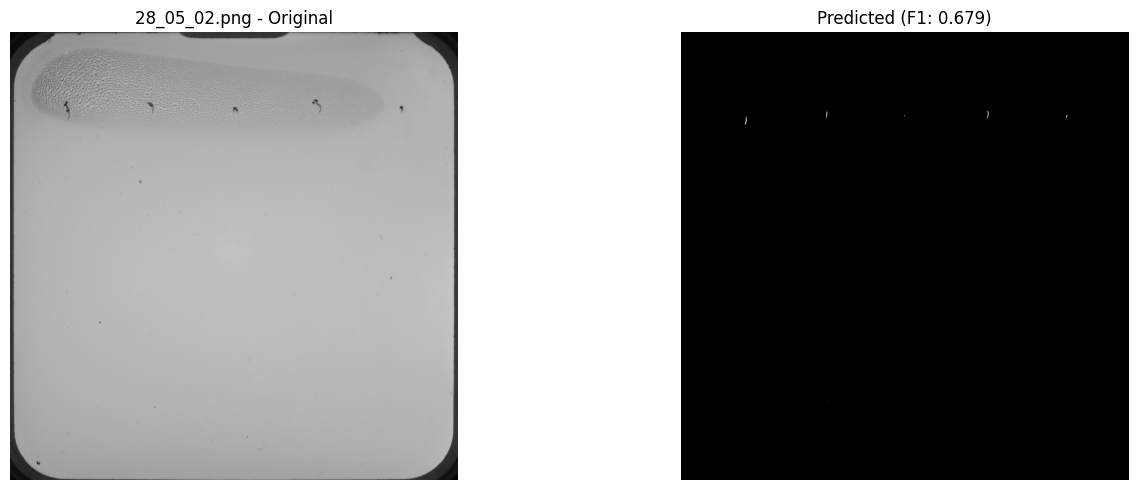

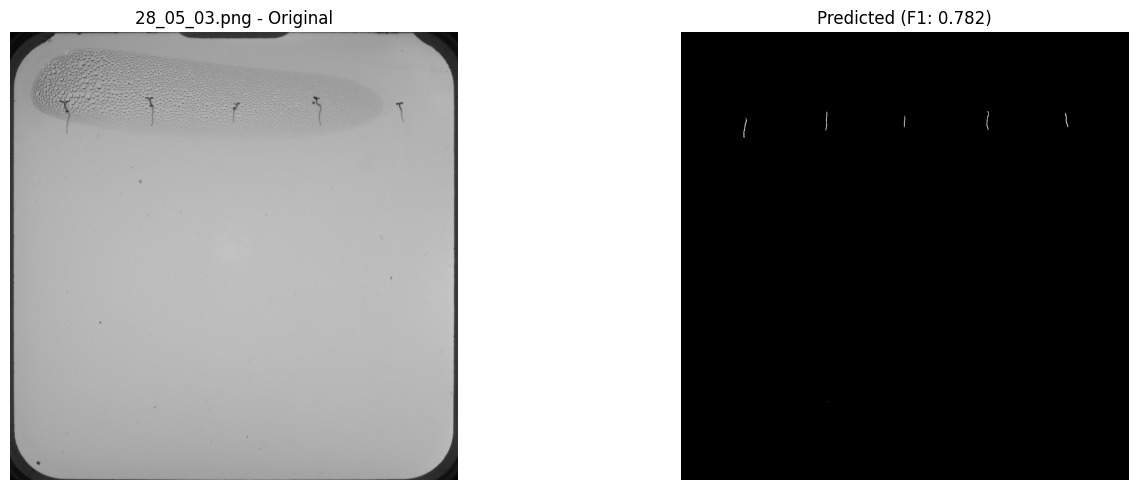

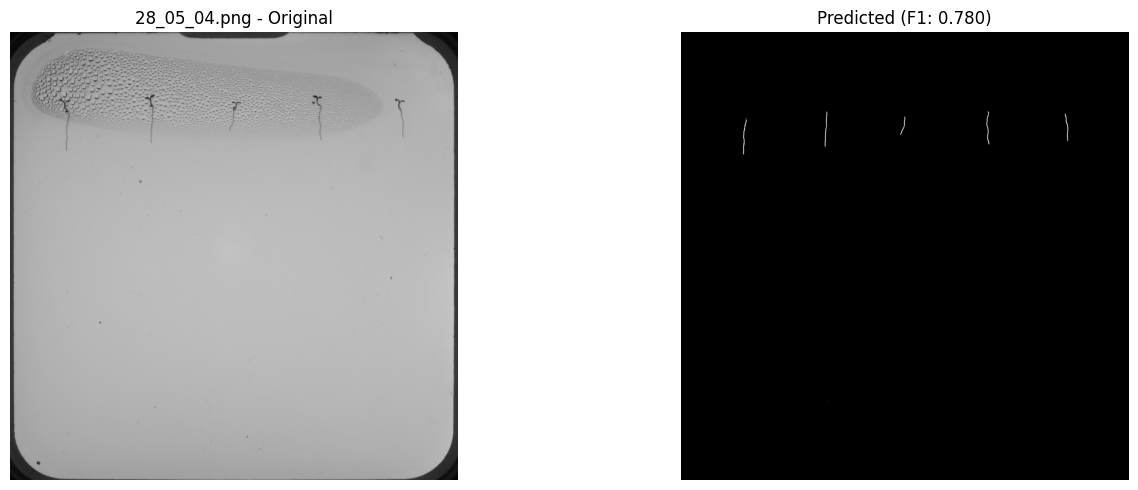

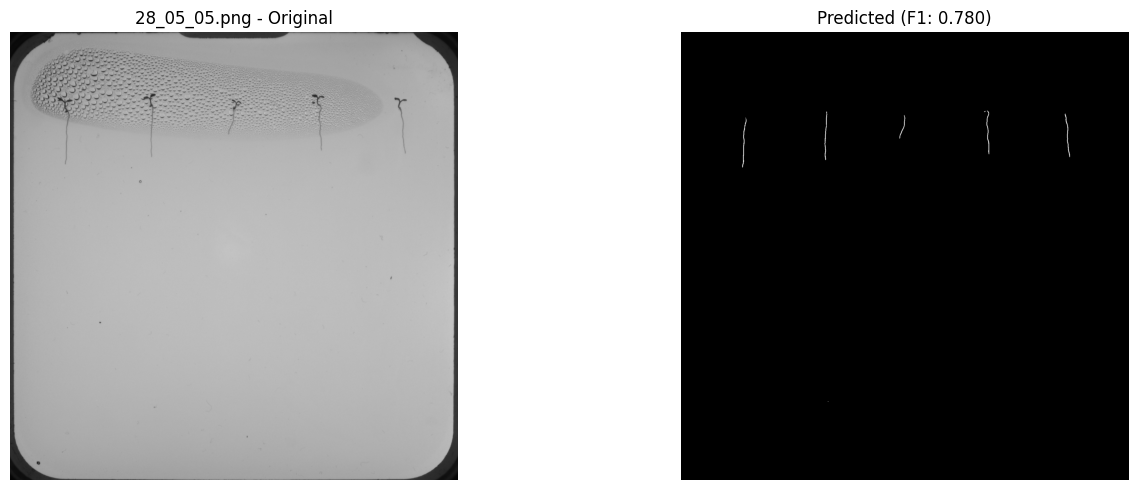

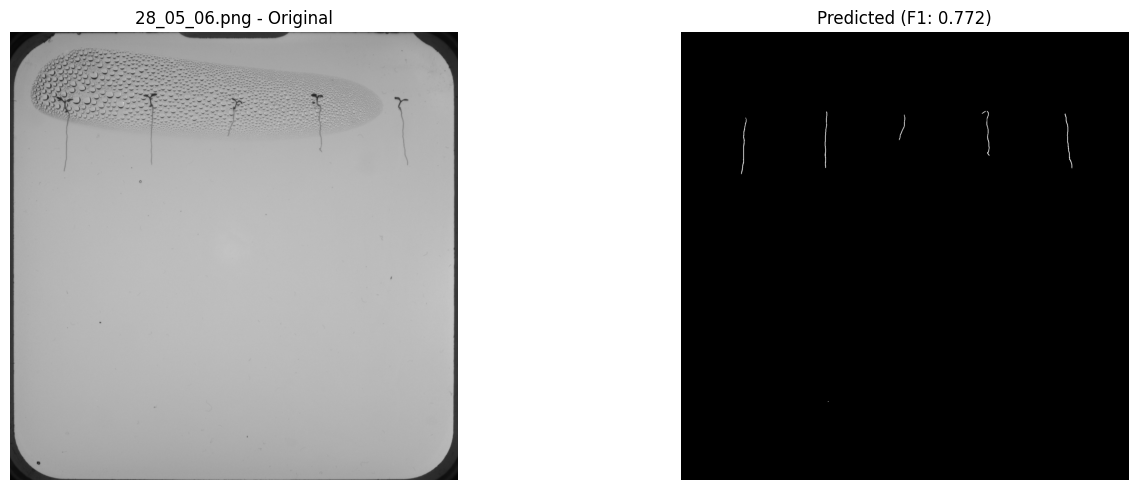

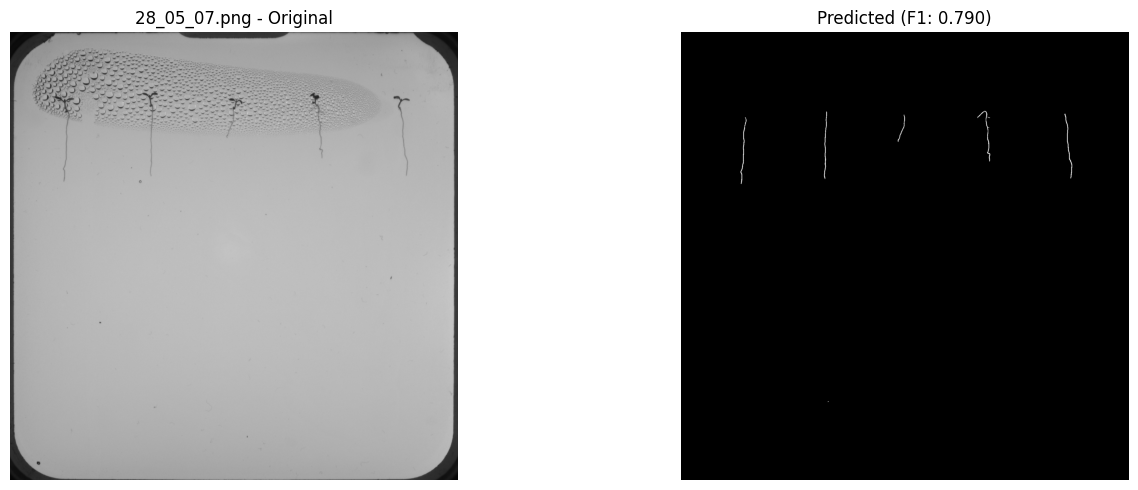

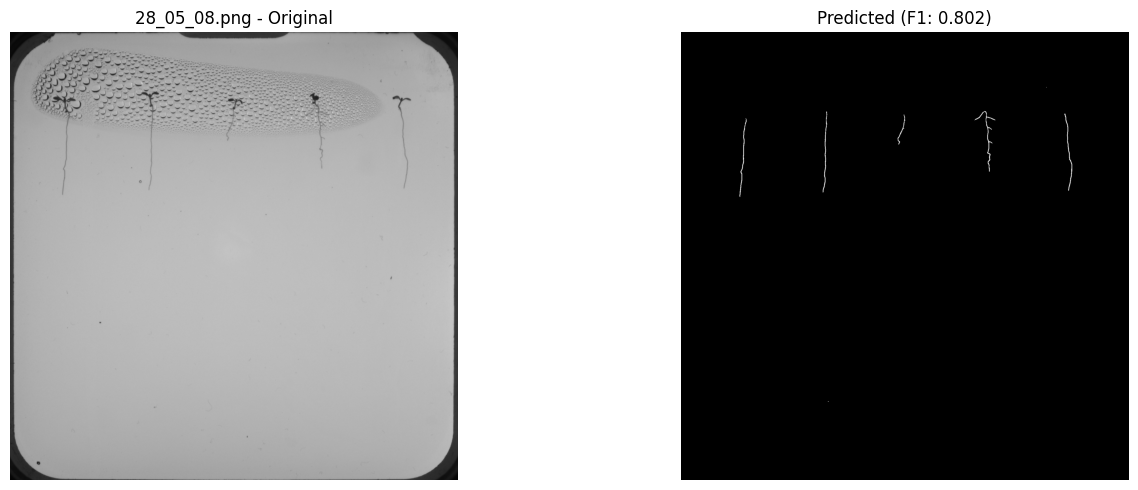

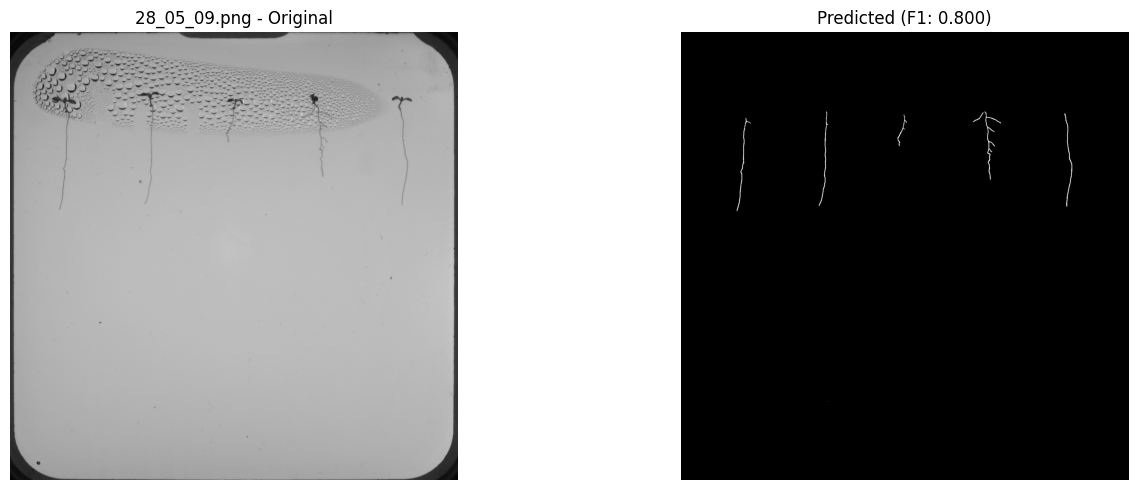

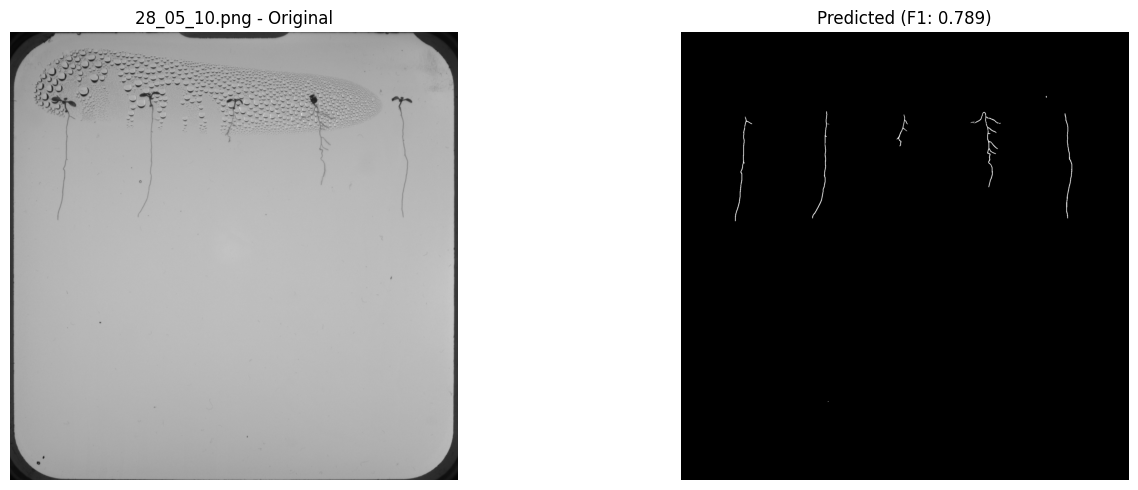

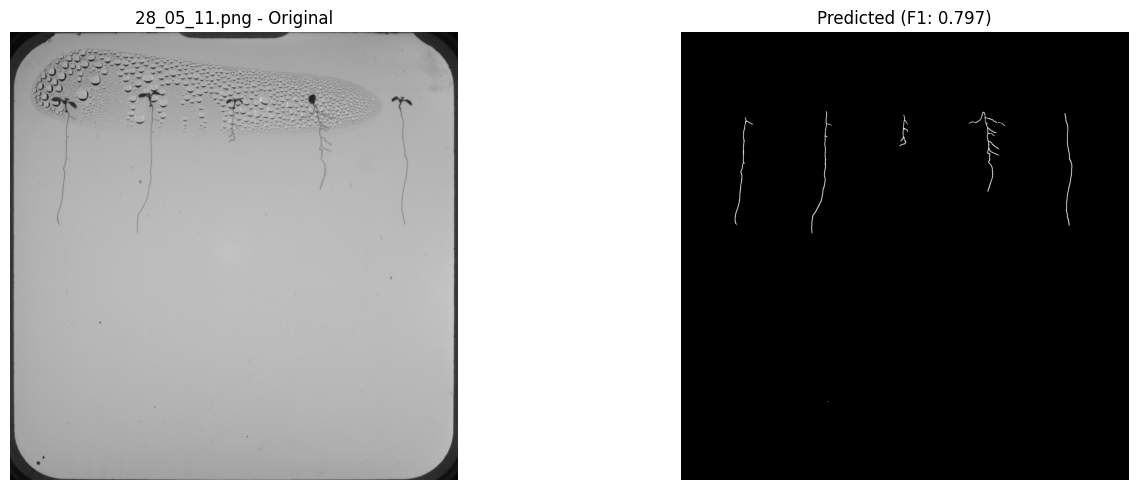

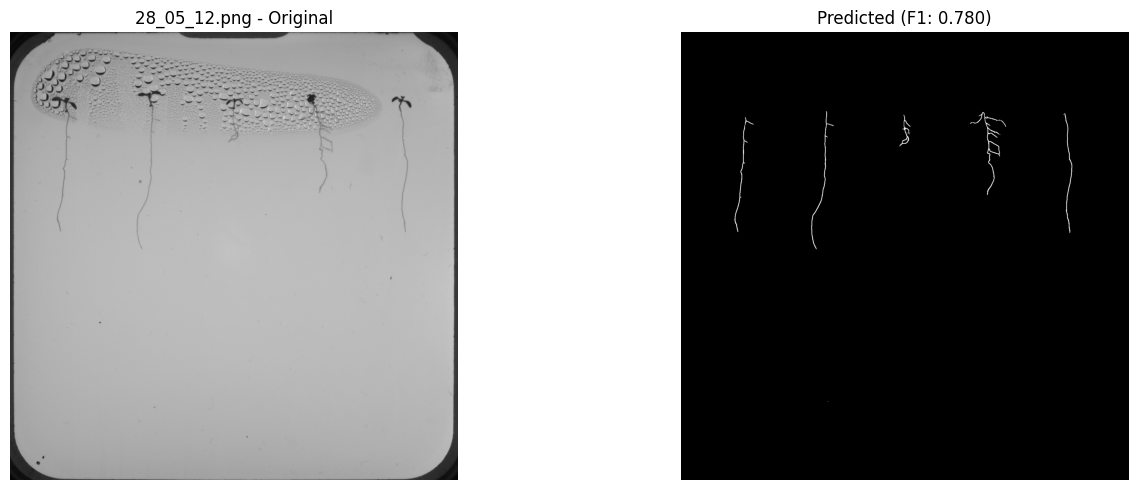

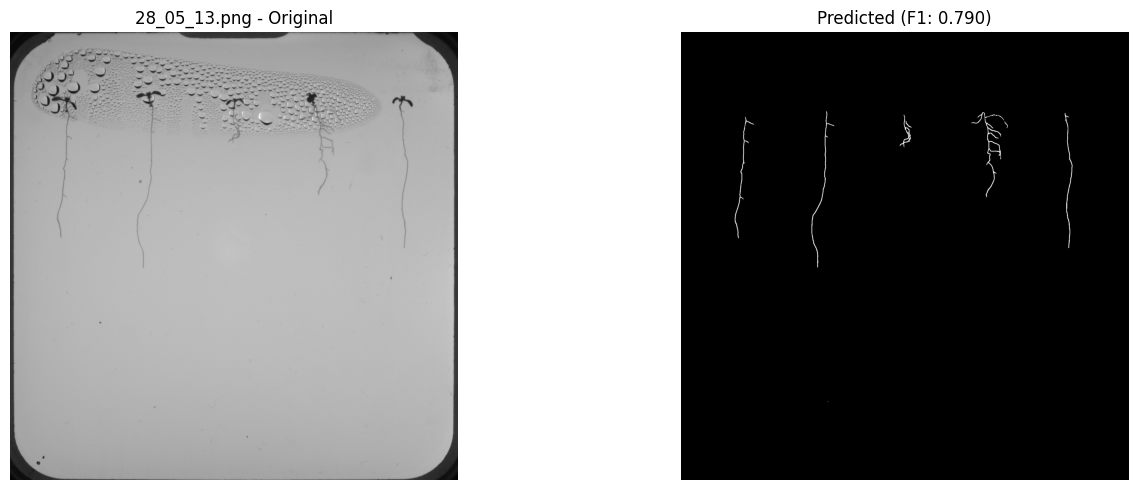

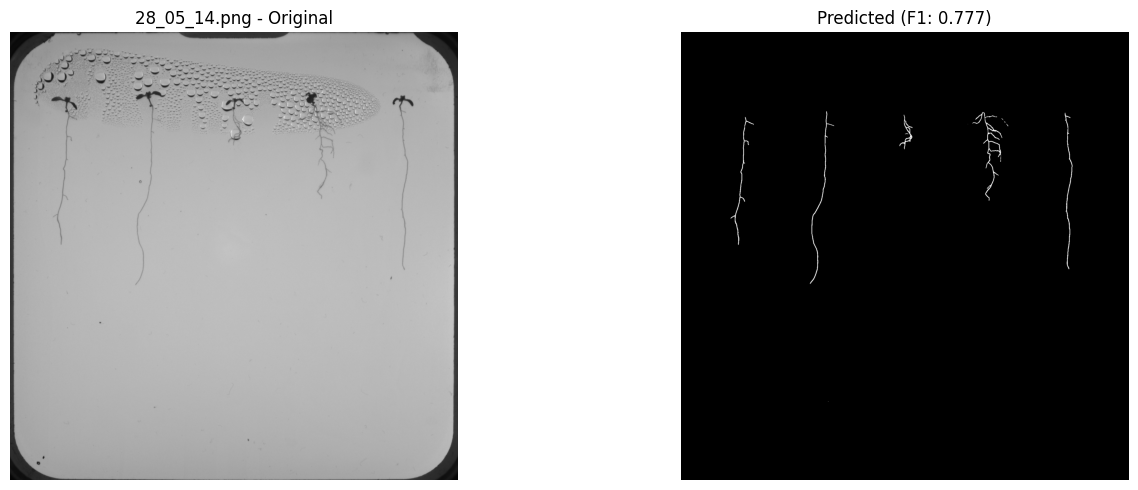

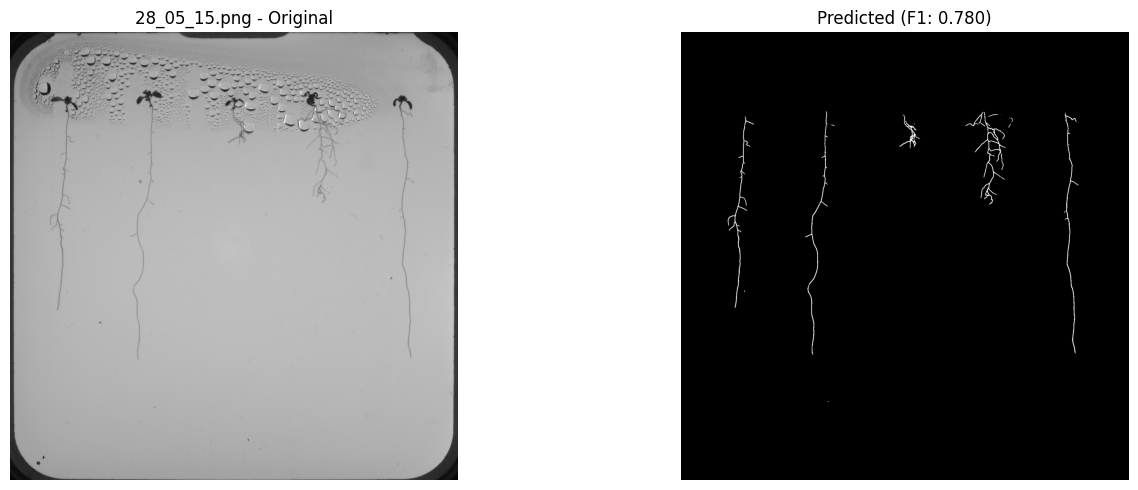

In [3]:
model_path = 'models/lstm_unet_run2.h5'
image_dir = "../LSTM-Unet/data_v3_processed/test"

model = load_model(model_path, custom_objects={"f1": f1})

metrics = inference_single_model(model, image_dir, time_steps=15, kernel_size=5, patch_size=256)

=== Black Padding ===


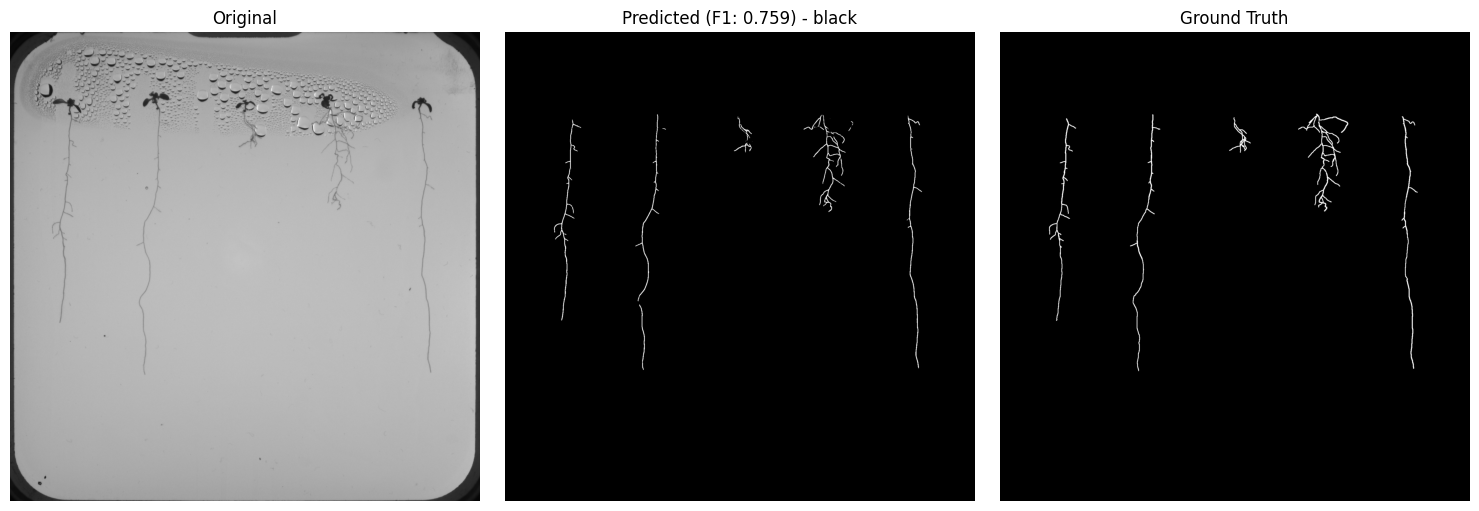


=== Repeated Frames ===


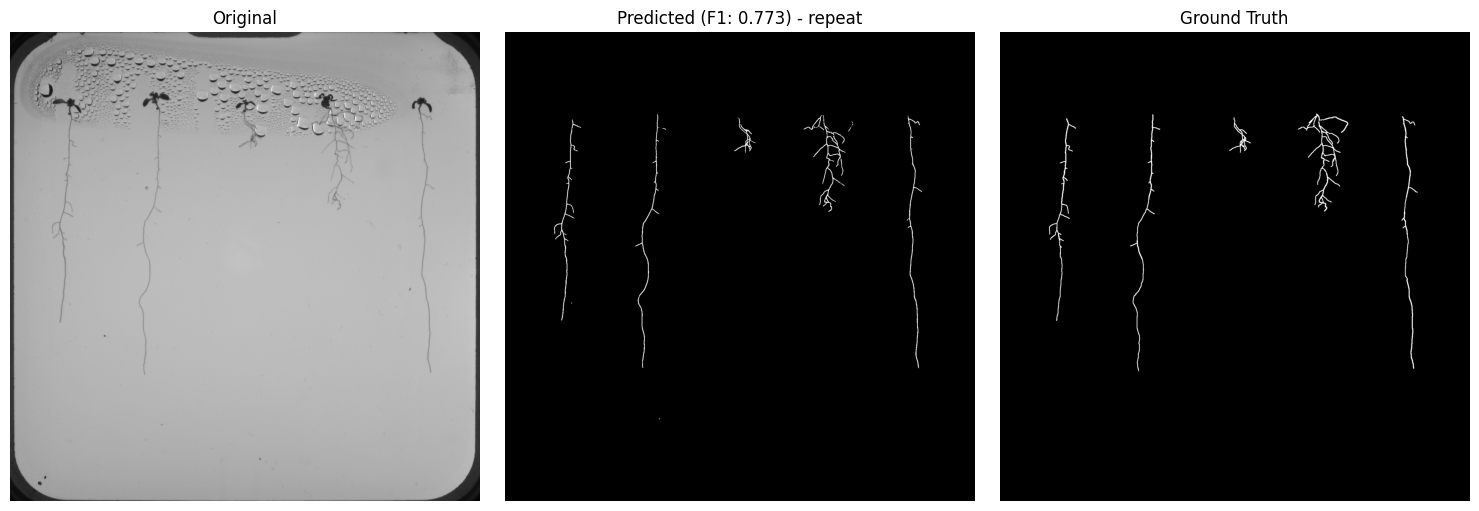

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
from tensorflow.keras.models import load_model
from sklearn.metrics import jaccard_score, precision_score, recall_score
from sklearn.metrics import f1_score as f1_metric
import pandas as pd
from datetime import datetime

from preprocess import crop, padder, crop_to_coordinates
from helpers import f1

def inference_single_image(model, image_path, time_steps=15, kernel_size=5, patch_size=256, padding_mode='black'):
    """
    Run inference on a single image with chosen padding strategy.
    
    Args:
        padding_mode: 'black' for black frame padding, 'repeat' for repeating the image
    """
    # Read and preprocess the single image
    image = cv2.imread(image_path, 0)
    image_cropped, stats, centroids = crop(image, kernel_size=kernel_size)
    image_color = cv2.cvtColor(image_cropped, cv2.COLOR_GRAY2RGB)
    image_np = image_color / 255.0
    image_padded = padder(image_np, patch_size=patch_size)
    
    H, W, C = image_padded.shape
    
    # Create sequence based on padding mode
    if padding_mode == 'black':
        # Black frames before, actual image at the end
        black_frame = np.zeros((H, W, C), dtype=np.float32)
        frames_padded = [black_frame] * (time_steps - 1) + [image_padded]
    else:  # 'repeat'
        # Repeat the same image for all time steps
        frames_padded = [image_padded] * time_steps
    
    frames_padded = np.array(frames_padded)  # (time_steps, H, W, 3)
    
    # Patchify all frames
    patches_seq = []
    for t in range(time_steps):
        patches = patchify(frames_padded[t], (patch_size, patch_size, 3), step=patch_size)
        patches_seq.append(patches)
    patches_seq = np.stack(patches_seq, axis=2)
    num_x, num_y = patches_seq.shape[:2]
    
    # Reshape to (num_patches, time_steps, patch_size, patch_size, 3)
    patches_seq = patches_seq.reshape(-1, time_steps, patch_size, patch_size, 3)
    
    # Predict masks for all time steps
    predicted_patches = model.predict(patches_seq, verbose=0)
    
    # Reshape back and get the last time step prediction
    predicted_patches = predicted_patches.reshape(num_x, num_y, time_steps, patch_size, patch_size)
    predicted_mask = unpatchify(predicted_patches[:, :, -1, :, :], (H, W))
    prediction_bool = (predicted_mask > 0.5).astype(np.uint8)
    
    # Load ground truth mask
    mask_path = image_path.replace('.png', '.tif')
    if os.path.exists(mask_path):
        mask = cv2.imread(mask_path, 0)
        mask = crop_to_coordinates(mask, stats, centroids)
        mask = padder(mask, patch_size=patch_size)
        mask_bool = (mask > 0.5).astype(np.uint8)
        
        # Compute metrics
        pred_flat = prediction_bool.flatten()
        mask_flat = mask_bool.flatten()
        f1_val = f1_metric(mask_flat, pred_flat)
        iou_val = jaccard_score(mask_flat, pred_flat)
        precision_val = precision_score(mask_flat, pred_flat, zero_division=0)
        recall_val = recall_score(mask_flat, pred_flat, zero_division=0)
        
        # Display
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(image_np)
        axs[0].set_title(f"Original")
        axs[0].axis("off")
        
        axs[1].imshow(prediction_bool, cmap='gray')
        axs[1].set_title(f"Predicted (F1: {f1_val:.3f}) - {padding_mode}")
        axs[1].axis("off")
        
        axs[2].imshow(mask_bool, cmap='gray')
        axs[2].set_title("Ground Truth")
        axs[2].axis("off")
        
        plt.tight_layout()
        plt.show()
        
        return {
            'f1': f1_val,
            'iou': iou_val,
            'precision': precision_val,
            'recall': recall_val,
            'padding_mode': padding_mode
        }
    else:
        # Just display prediction without metrics
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image_np)
        axs[0].set_title("Original")
        axs[0].axis("off")
        
        axs[1].imshow(prediction_bool, cmap='gray')
        axs[1].set_title(f"Predicted - {padding_mode}")
        axs[1].axis("off")
        
        plt.tight_layout()
        plt.show()
        
        return None

# Usage:
model_path = 'models/lstm_unet_run2.h5'
image_path = "../LSTM-Unet/data_v3_processed/test/28_05_15.png"
model = load_model(model_path, custom_objects={"f1": f1})

# Test with black padding
print("=== Black Padding ===")
metrics_black = inference_single_image(model, image_path, time_steps=15, padding_mode='black')

# Test with repeated frames
print("\n=== Repeated Frames ===")
metrics_repeat = inference_single_image(model, image_path, time_steps=15, padding_mode='repeat')

Found 5 models to evaluate:
  - lstm_unet_run5.h5
  - lstm_unet_run3.h5
  - lstm_unet_run1.h5
  - lstm_unet_run4.h5
  - lstm_unet_run2.h5


Processing model 1/5: lstm_unet_run5
Skipping frame 28_05_01.png as ground truth has no positive pixels.
=== Average Metrics ===
Avg F1 Score: 0.7468
Avg mIoU: 0.5985
Avg Precision: 0.9358
Avg Recall: 0.6250


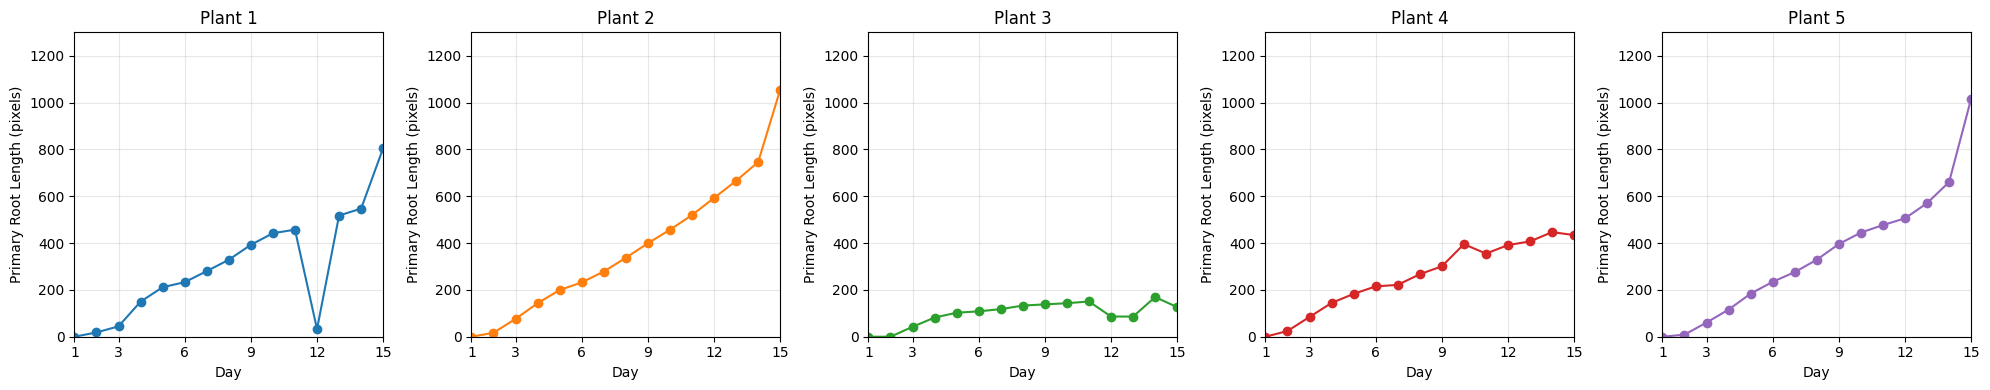


  Results for lstm_unet_run5:
    F1 Score:  0.7468
    mIoU:      0.5985
    Precision: 0.9358
    Recall:    0.6250
    Frames:    14


Processing model 2/5: lstm_unet_run3
Skipping frame 28_05_01.png as ground truth has no positive pixels.
=== Average Metrics ===
Avg F1 Score: 0.7681
Avg mIoU: 0.6241
Avg Precision: 0.8758
Avg Recall: 0.6858


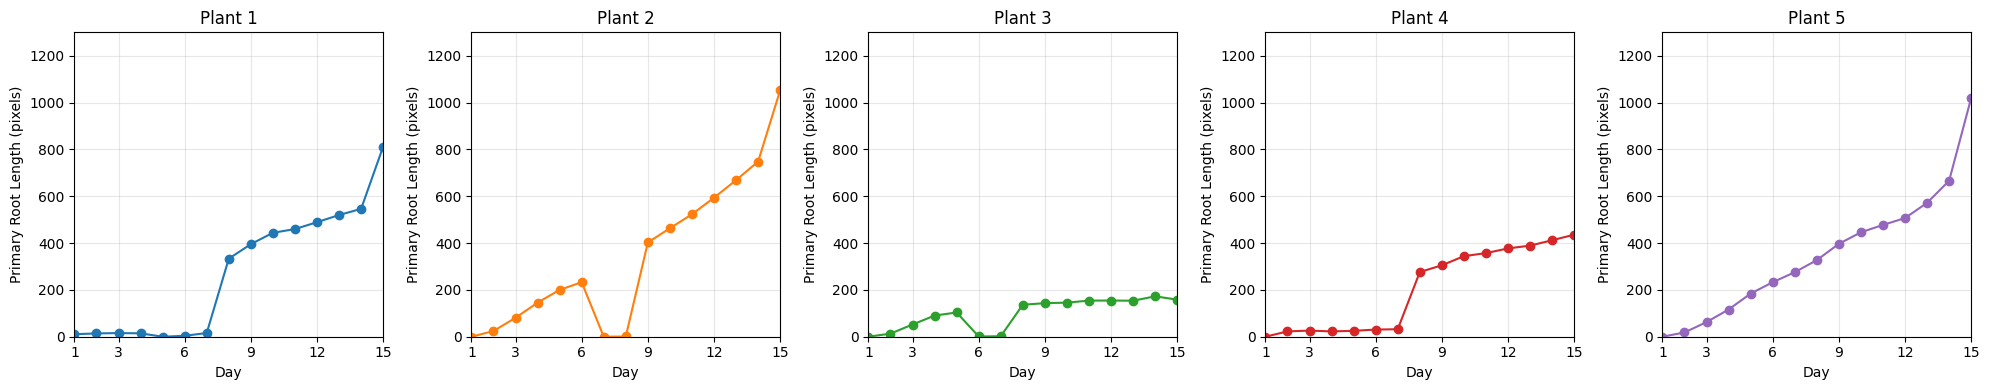


  Results for lstm_unet_run3:
    F1 Score:  0.7681
    mIoU:      0.6241
    Precision: 0.8758
    Recall:    0.6858
    Frames:    14


Processing model 3/5: lstm_unet_run1
Skipping frame 28_05_01.png as ground truth has no positive pixels.
=== Average Metrics ===
Avg F1 Score: 0.7692
Avg mIoU: 0.6252
Avg Precision: 0.9285
Avg Recall: 0.6571


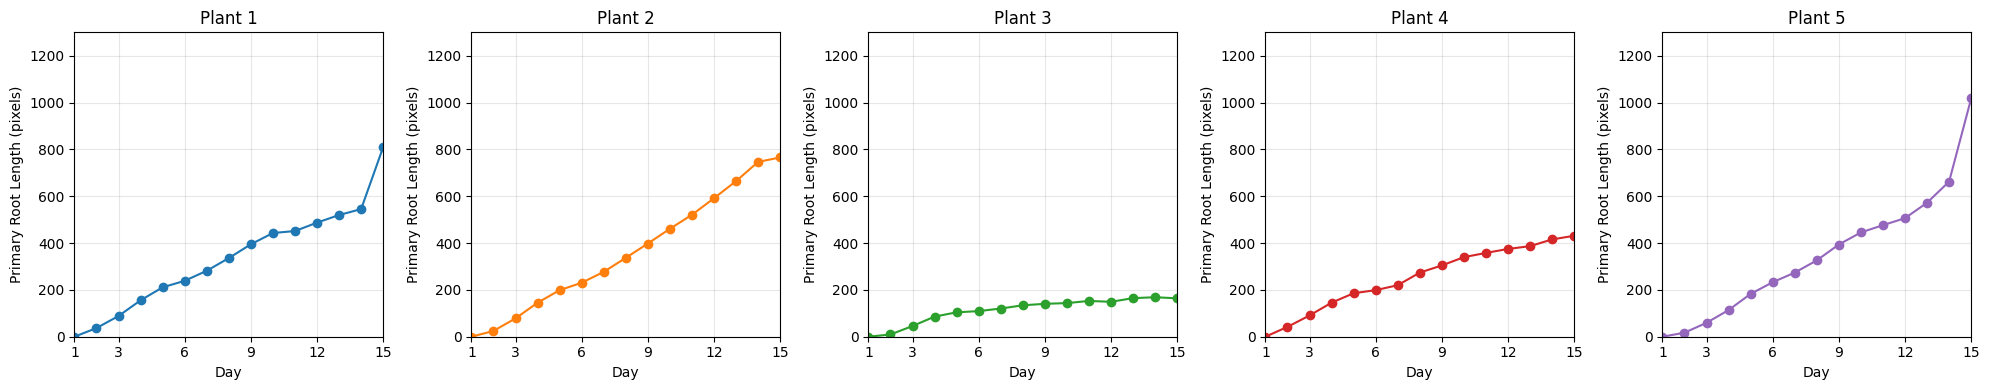


  Results for lstm_unet_run1:
    F1 Score:  0.7692
    mIoU:      0.6252
    Precision: 0.9285
    Recall:    0.6571
    Frames:    14


Processing model 4/5: lstm_unet_run4
Skipping frame 28_05_01.png as ground truth has no positive pixels.
=== Average Metrics ===
Avg F1 Score: 0.7815
Avg mIoU: 0.6416
Avg Precision: 0.9098
Avg Recall: 0.6856


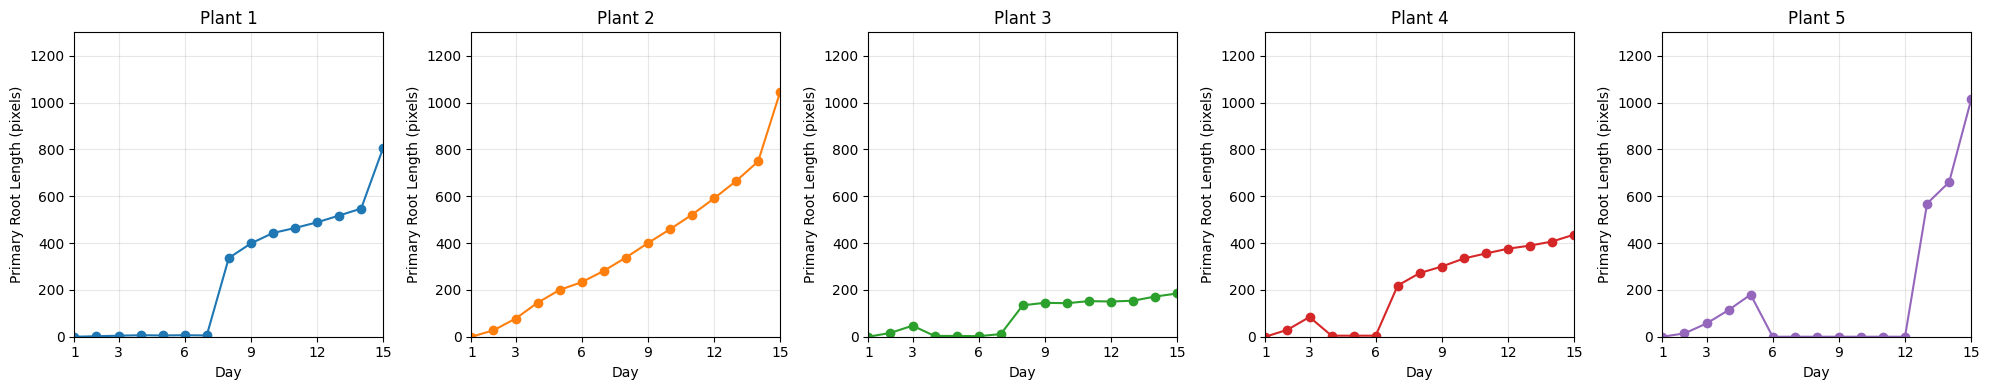


  Results for lstm_unet_run4:
    F1 Score:  0.7815
    mIoU:      0.6416
    Precision: 0.9098
    Recall:    0.6856
    Frames:    14


Processing model 5/5: lstm_unet_run2
Skipping frame 28_05_01.png as ground truth has no positive pixels.
=== Average Metrics ===
Avg F1 Score: 0.7784
Avg mIoU: 0.6381
Avg Precision: 0.9230
Avg Recall: 0.6753


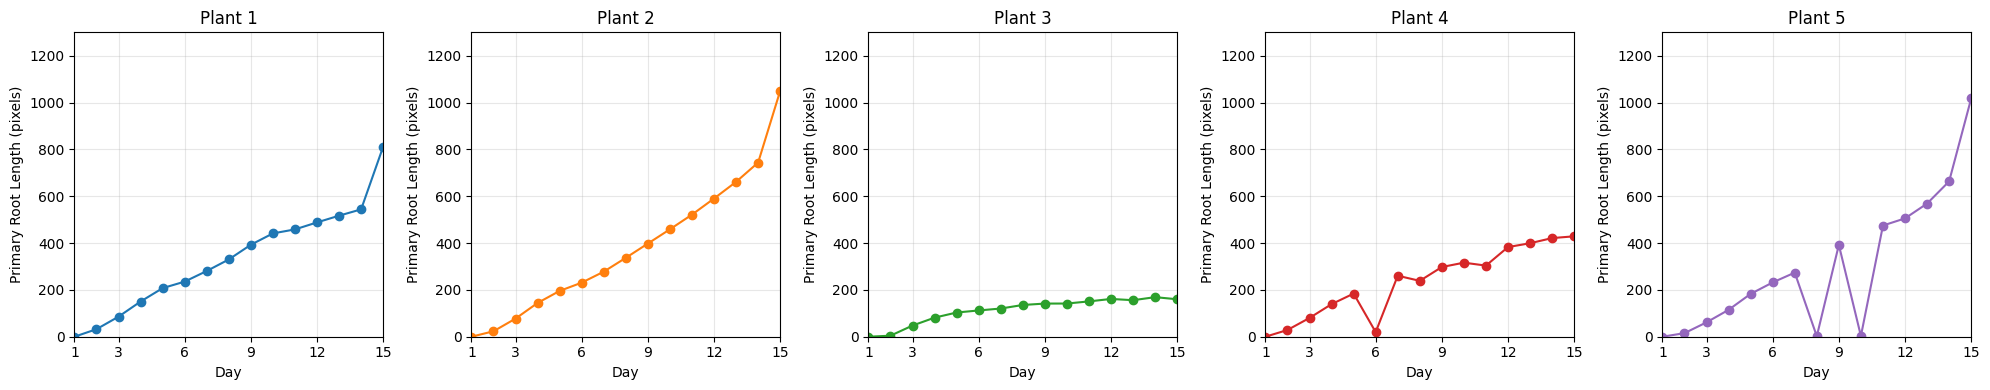


  Results for lstm_unet_run2:
    F1 Score:  0.7784
    mIoU:      0.6381
    Precision: 0.9230
    Recall:    0.6753
    Frames:    14



SUMMARY OF ALL MODELS
    model_name       f1      iou  precision   recall  num_frames        model_file
lstm_unet_run4 0.781510 0.641594   0.909780 0.685553          14 lstm_unet_run4.h5
lstm_unet_run2 0.778407 0.638068   0.923020 0.675298          14 lstm_unet_run2.h5
lstm_unet_run1 0.769206 0.625227   0.928502 0.657114          14 lstm_unet_run1.h5
lstm_unet_run3 0.768121 0.624114   0.875848 0.685837          14 lstm_unet_run3.h5
lstm_unet_run5 0.746770 0.598493   0.935773 0.625050          14 lstm_unet_run5.h5

BEST MODEL: lstm_unet_run4
  F1 Score:  0.7815
  mIoU:      0.6416


In [5]:
### Getting line plot for length of primary root
from inference import pipeline
import os
from tensorflow.keras.models import load_model
from helpers import f1

# Configuration
MODELS_DIR = "models"  # Directory containing all your trained models
IMAGE_DIR = "../LSTM-Unet/data_v3_processed/test"
TIME_STEPS = 15
KERNEL_SIZE = 5
PATCH_SIZE = 256

# Run inference on all models
results_df = pipeline(
    models_dir=MODELS_DIR,
    image_dir=IMAGE_DIR,
    time_steps=TIME_STEPS,
    kernel_size=KERNEL_SIZE,
    patch_size=PATCH_SIZE,
    model_extensions=['.h5'],  # Add any other extensions you use
    save_results=False,
    view_masks=False,
    view_growth=True
)